# Identifying Student Favorite Activities

In [34]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from joblib import dump, load
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

%matplotlib inline

## 1. Load Data

In [35]:
data_mahasiswa=pd.read_csv("../MHS.csv")
data_kegiatan=pd.read_csv("../SA.csv")


## 2. Data Preprocessing

Model saved to student-activity-recommender.joblib
Model loaded from student-activity-recommender.joblib
Recommendations for Student 2231152:
developing         6.971281
aws                5.708109
work               5.684461
mbkm               2.730497
internetworking    2.650519
dtype: float64


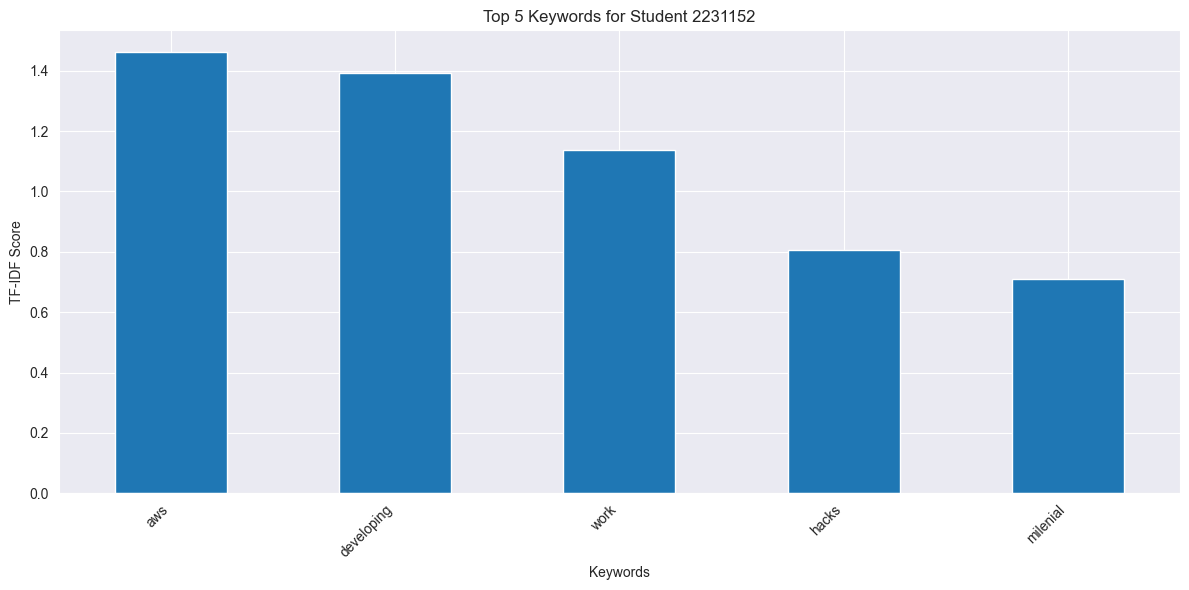

In [45]:
# Define custom stop words
def get_custom_stop_words():
    return set([
        # English stop words
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        # English words
        'ready', 'seminar', 'webinar', 'uib', 'local', 'national', 'international',
        'lokal', 'nasional', 'internasional', 'lgbt', 'series', 'club', 'meeting', 'conversation',
        'get', 'self', 'learning', 'skills', 'out', 'find', 'your', 'beginners', 'beginner', 'learn',
        'course', 'fundamentals', 'pengembangan', 'kepribadian', 'how', 'rules', 'about', 'collaboration',
        # Indonesian stop words
        'yang', 'di', 'ke', 'dari', 'dalam', 'pada', 'dengan', 'dan', 'atau',
        # Bahasa Indonesia words
        'ukm', 'merdeka', 'jam', 'belajar', 'sertifikasi', 'generasi', 
        # Conjunctions
        'namun', 'tetapi', 'akan', 'serta', 'karena', 'sebab',
        # Numbers and years (generic removal)
        '2020', '2021', '2022', '2023', '2024',
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        # Additional filtering
    ])

# Fit TF-IDF model and create student profiles
def fit_tfidf_model(activities, student_ids, stop_words=None):
    if stop_words is None:
        stop_words = get_custom_stop_words()

    # Create TF-IDF Vectorizer
    tfidf = TfidfVectorizer(stop_words=list(stop_words))
    tfidf_matrix = tfidf.fit_transform(activities)

    # Get feature names (keywords)
    keywords = tfidf.get_feature_names_out()

    # Create student profiles by aggregating keywords
    activity_keywords = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=keywords,
        index=student_ids
    )
    student_profiles = activity_keywords.groupby(activity_keywords.index).sum()

    return {
        'tfidf': tfidf,
        'tfidf_matrix': tfidf_matrix,
        'keywords': keywords,
        'student_profiles': student_profiles
    }

# Find similar students based on their keyword profiles
def find_similar_students(student_id, student_similarity_df, top_n=5):
    if student_id not in student_similarity_df.index:
        raise KeyError(f"Student ID {student_id} not found.")
    
    # Sort similar students
    similar_students = student_similarity_df.loc[student_id].sort_values(ascending=False)
    return similar_students.head(top_n + 1).iloc[1:]  # Exclude the student themselves

# Recommend keywords based on similar students
def recommend_based_on_similar_students(student_id, student_similarity_df, student_keyword_matrix, top_n=5):
    similar_students = find_similar_students(student_id, student_similarity_df).index
    # Aggregate keywords from similar students
    similar_profiles = student_keyword_matrix.loc[similar_students].sum(axis=0)
    # Sort and recommend top keywords
    return similar_profiles.sort_values(ascending=False).head(top_n)

# Recommend keywords for a specific student
def recommend_keywords(student_id, student_profiles, keywords, top_n=5):
    if student_id not in student_profiles.index:
        raise KeyError(f"Student ID {student_id} not found.")

    # Sort keywords by importance for the student
    student_keywords = student_profiles.loc[student_id].sort_values(ascending=False)
    return student_keywords.head(top_n)

# Visualize top keywords for a student
def visualize_student_keywords(student_id, student_profiles, top_n=5):
    try:
        top_keywords = recommend_keywords(student_id, student_profiles, None, top_n)
        plt.figure(figsize=(12, 6))
        top_keywords.plot(kind='bar')
        plt.title(f'Top {top_n} Keywords for Student {student_id}')
        plt.xlabel('Keywords')
        plt.ylabel('TF-IDF Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    except KeyError as e:
        print(e)

# Main function to build the model and compute similarities
def build_student_recommendation_model(data_kegiatan):
    # Fit the model
    model_components = fit_tfidf_model(data_kegiatan['nama_kegiatan'], data_kegiatan['npm'])

    # Compute student similarity matrix
    student_keyword_matrix = model_components['student_profiles']
    student_similarity = cosine_similarity(student_keyword_matrix)
    student_similarity_df = pd.DataFrame(
        student_similarity,
        index=student_keyword_matrix.index,
        columns=student_keyword_matrix.index
    )

    return {
        'model_components': model_components,
        'student_similarity_df': student_similarity_df
    }

# Save the model
def save_model(model, filepath):
    dump(model, filepath)
    print(f"Model saved to {filepath}")

# Load the model
def load_model(filepath):
    model = load(filepath)
    print(f"Model loaded from {filepath}")
    return model

# Example usage
if __name__ == "__main__":
    # Load data
    data_kegiatan = pd.read_csv("../SA.csv")

    # Build the model
    recommendation_model = build_student_recommendation_model(data_kegiatan)
    model_components = recommendation_model['model_components']
    student_similarity_df = recommendation_model['student_similarity_df']

    # Save the model
    save_model(recommendation_model, "student-activity-recommender.joblib")

    # Load the model
    loaded_model = load_model("student-activity-recommender.joblib")
    loaded_model_components = loaded_model['model_components']
    loaded_student_similarity_df = loaded_model['student_similarity_df']

    # Example student ID
    student_id = 2231152

    # Recommend keywords for the student
    try:
        recommended_keywords = recommend_based_on_similar_students(
            student_id,
            loaded_student_similarity_df,
            loaded_model_components['student_profiles']
        )
        print(f"Recommendations for Student {student_id}:")
        print(recommended_keywords)

        # Visualize the student's keyword profile
        visualize_student_keywords(student_id, loaded_model_components['student_profiles'])

    except KeyError as e:
        print(e)
